<a href="https://colab.research.google.com/github/lapythie/ml/blob/master/HW06_ML__nn_intro_quora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import spacy
# для лемматизации, делать её будем в последнюю очередь
nlp = spacy.load("en_core_web_sm", \
                     disable=['ner', 'parser', 'tagger', 'textcat', 'tokenizer'])

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import gensim
from sklearn.metrics import classification_report
from string import punctuation
punctuation += '«»—–…“”‘•'
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

Фасттекст и quora

Задание: 
1) На одной из задач сравните, что лучше:

а) конкатенировать эмбединги в один большой эмбединг, 

б) усреднять эмбединги, 

в) складывать эмбединги. 

Зафиксируйте разбиение на train_test через random_seed, чтобы обучаться и оцениваться на одних и тех же данных. Параметры нейронок не нужно делать одинаковыми. Просто попробуйте добиться максимума от каждого из подходов.

In [ ]:
def lemmatize(text):
    tokens = ' '.join([token.strip(punctuation) for token in text.split()])
    tokens = [token.lemma_.lower() if token.lemma_ != '-PRON-' else token.lemma_ for token in nlp(tokens)]
    return tokens

In [ ]:
quora = pd.read_csv('/content/drive/My Drive/Colab Notebooks/homework_ml_m1/HW06_ML_NN_INTRO/quora.csv')

In [ ]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

# len(vocab)

In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 50:
        filtered_vocab.add(word)

# len(filtered_vocab)

In [ ]:
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [ ]:
X=[]

for text in quora.question_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, word2id['UNK']) for token in tokens]
    X.append(ids)

MAX_LEN = max(len(x) for x in X)
MAX_LEN

134

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape

(223549, 512)

In [ ]:
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=MAX_LEN)
X_val.shape

(8000, 512)

In [ ]:
y = quora.target.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)

# *1) На одной из задач сравните, что лучше: а) конкатенировать эмбединги в один большой эмбединг, б) усреднять эмбединги, в) складывать эмбединги.*

*Зафиксируйте разбиение на train_test через random_seed, чтобы обучаться и оцениваться на одних и тех же данных. Параметры нейронок не нужно делать одинаковыми. Просто попробуйте добиться максимума от каждого из подходов.*

## Конкатенация

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(word2id), output_dim=200)(inputs, )
mean = tf.keras.layers.Flatten()(embeddings)
dense1 = tf.keras.layers.Dense(64, activation='relu')(mean)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(64, activation='relu')(dense2)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=10)

Epoch 1/10
2424/2424 [==============================] - 403s 166ms/step - loss: 0.1430 - accuracy: 0.9479 - val_loss: 0.1141 - val_accuracy: 0.9549
Epoch 2/10
2424/2424 [==============================] - 410s 169ms/step - loss: 0.1114 - accuracy: 0.9549 - val_loss: 0.1112 - val_accuracy: 0.9559
Epoch 3/10
2424/2424 [==============================] - 405s 167ms/step - loss: 0.1059 - accuracy: 0.9568 - val_loss: 0.1128 - val_accuracy: 0.9562
Epoch 4/10
2424/2424 [==============================] - 392s 162ms/step - loss: 0.1008 - accuracy: 0.9586 - val_loss: 0.1139 - val_accuracy: 0.9555
Epoch 5/10
2424/2424 [==============================] - 406s 167ms/step - loss: 0.0946 - accuracy: 0.9613 - val_loss: 0.1198 - val_accuracy: 0.9548
Epoch 6/10
2424/2424 [==============================] - 408s 168ms/step - loss: 0.0869 - accuracy: 0.9647 - val_loss: 0.1242 - val_accuracy: 0.9531
Epoch 7/10
2424/2424 [==============================] - 394s 163ms/step - loss: 0.0786 - accuracy: 0.9688 - val_

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


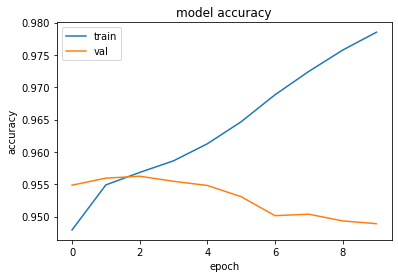

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
preds = model.predict(X_valid).reshape(-1)

In [ ]:
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     61365
           1       0.60      0.47      0.52      3942

    accuracy                           0.95     65307
   macro avg       0.78      0.72      0.75     65307
weighted avg       0.94      0.95      0.95     65307



## Усреднение

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(word2id), output_dim=200)(inputs, )
# mean = tf.keras.layers.Flatten()(embeddings) 
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1))(embeddings)
dense1 = tf.keras.layers.Dense(64, activation='relu')(mean)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(64, activation='relu')(dense2)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=10)

Epoch 1/10
2424/2424 [==============================] - 184s 76ms/step - loss: 0.2226 - accuracy: 0.9376 - val_loss: 0.1375 - val_accuracy: 0.9489
Epoch 2/10
2424/2424 [==============================] - 183s 75ms/step - loss: 0.1297 - accuracy: 0.9498 - val_loss: 0.1198 - val_accuracy: 0.9532
Epoch 3/10
2424/2424 [==============================] - 182s 75ms/step - loss: 0.1189 - accuracy: 0.9525 - val_loss: 0.1151 - val_accuracy: 0.9543
Epoch 4/10
2424/2424 [==============================] - 166s 68ms/step - loss: 0.1145 - accuracy: 0.9539 - val_loss: 0.1134 - val_accuracy: 0.9548
Epoch 5/10
2424/2424 [==============================] - 166s 68ms/step - loss: 0.1121 - accuracy: 0.9546 - val_loss: 0.1126 - val_accuracy: 0.9550
Epoch 6/10
2424/2424 [==============================] - 167s 69ms/step - loss: 0.1104 - accuracy: 0.9552 - val_loss: 0.1126 - val_accuracy: 0.9555
Epoch 7/10
2424/2424 [==============================] - 166s 68ms/step - loss: 0.1092 - accuracy: 0.9556 - val_loss: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


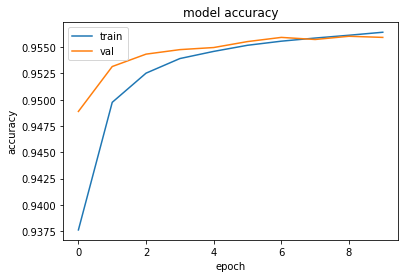

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
preds = model.predict(X_valid).reshape(-1)

In [ ]:
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     61365
           1       0.68      0.51      0.58      3942

    accuracy                           0.96     65307
   macro avg       0.82      0.75      0.78     65307
weighted avg       0.95      0.96      0.95     65307



## Суммирование

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(word2id), output_dim=200)(inputs, )
# mean = tf.keras.layers.Flatten()(embeddings) 
# mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1))(embeddings)
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings)
dense1 = tf.keras.layers.Dense(64, activation='relu')(mean)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(64, activation='relu')(dense2)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=10)

Epoch 1/10
2424/2424 [==============================] - 159s 66ms/step - loss: 0.1421 - accuracy: 0.9486 - val_loss: 0.1158 - val_accuracy: 0.9548
Epoch 2/10
2424/2424 [==============================] - 159s 65ms/step - loss: 0.1143 - accuracy: 0.9545 - val_loss: 0.1138 - val_accuracy: 0.9560
Epoch 3/10
2424/2424 [==============================] - 158s 65ms/step - loss: 0.1101 - accuracy: 0.9559 - val_loss: 0.1157 - val_accuracy: 0.9555
Epoch 4/10
2424/2424 [==============================] - 157s 65ms/step - loss: 0.1071 - accuracy: 0.9571 - val_loss: 0.1124 - val_accuracy: 0.9552
Epoch 5/10
2424/2424 [==============================] - 159s 66ms/step - loss: 0.1045 - accuracy: 0.9580 - val_loss: 0.1109 - val_accuracy: 0.9565
Epoch 6/10
2424/2424 [==============================] - 161s 67ms/step - loss: 0.1022 - accuracy: 0.9590 - val_loss: 0.1133 - val_accuracy: 0.9567
Epoch 7/10
2424/2424 [==============================] - 163s 67ms/step - loss: 0.0998 - accuracy: 0.9598 - val_loss: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


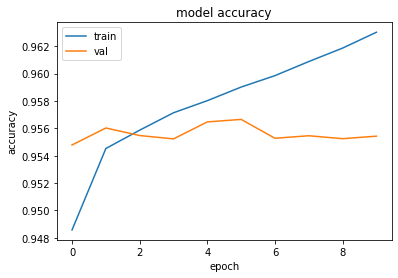

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
preds = model.predict(X_valid).reshape(-1)

In [ ]:
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     61365
           1       0.65      0.57      0.61      3942

    accuracy                           0.96     65307
   macro avg       0.81      0.78      0.79     65307
weighted avg       0.95      0.96      0.95     65307



**Кажется, что суммирование работает лучше всего.**

# *2) В одной из задач используйте сразу две предобученные эмбединг модели (можно фастекст и ворд2век, а можно просто 2 фастекста с разными параметрами) в одной нейронке.*

*Попробуйте усреднять эмбединги и конкатенировать (общие эмбединги потом в один вектор собирайте любым способом - например, тем который оказался лучше в первой задаче).*

*Подсказка: используйте functional api, сделайте два Embedding слоя и к их выходам примените слой Concatenate([emb1, emb2)) или Average([emb1, emb2))*

*Бонусный балл можно получить за эксперименты с параметрами в Embbeding, Dense (поизучайте другие существующие параметры и попробуйте комбинировать несколько слоев с разным активациями) слоях, а также за эксперименты с улучшением нормализации.*

## Первый фасттекст, почти дефолтный

In [ ]:
texts = quora.question_text.apply(preprocess).tolist()

In [ ]:
%%time
ft = gensim.models.FastText(texts, size=200, iter=2)

CPU times: user 6min 51s, sys: 3.2 s, total: 6min 54s
Wall time: 3min 47s


In [ ]:
ft.most_similar('xcfghjedfgbnjk')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('yu', 0.8668746948242188),
 ('ao', 0.8360617160797119),
 ('az', 0.834072470664978),
 ('ez', 0.8272629976272583),
 ('zhao', 0.8266050815582275),
 ('zayn', 0.8249717950820923),
 ('kuei', 0.8245311975479126),
 ('zuko', 0.8212680220603943),
 ('j.k', 0.8212662935256958),
 ('f.c', 0.8169491291046143)]

In [ ]:
weights = np.zeros((len(word2id), 200))
for word, i in word2id.items():
    if word == 'PAD':
        continue
    if word == 'UNK':
        weights[i] = ft['cmurrvntbcmirbycw']
    
    try:
        weights[i] = ft[word]
    except KeyError:
        weights[i] = ft['xcfghjedfgbnjk']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Второй фасттекст

In [ ]:
%%time
ft2 = gensim.models.FastText(texts, size=200, window=10, min_count=2, iter=10)

CPU times: user 40min 11s, sys: 5.33 s, total: 40min 16s
Wall time: 20min 54s


In [ ]:
ft2.most_similar('abortion')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('pro-abortion', 0.951040506362915),
 ('anti-abortion', 0.9148094654083252),
 ('abortions', 0.9044116139411926),
 ('abortive', 0.8647822141647339),
 ('extortion', 0.8437422513961792),
 ('anti-abortionist', 0.8307942152023315),
 ('aborting', 0.8239808082580566),
 ('abort', 0.81410813331604),
 ('aborts', 0.8089629411697388),
 ('contortion', 0.7909154891967773)]

In [ ]:
weights2 = np.zeros((len(word2id), 200))
for word, i in word2id.items():
    if word == 'PAD':
        continue
    if word == 'UNK':
        weights2[i] = ft2['qzowozmixwm']
    
    try:
        weights2[i] = ft2[word]
    except KeyError:
        weights2[i] = ft2['fhslhdslfhgdku']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


## Обучение

## Усреднять, а потом суммировать

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                       trainable=False, weights=[weights])(inputs)
embeddings2 = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                        trainable=False, weights=[weights2])(inputs)
emb = tf.keras.layers.Average()([embeddings, embeddings2])
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(emb)
dense1 = tf.keras.layers.Dense(64, activation='relu')(mean)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(64, activation='relu')(dense2)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=30)

Epoch 1/30
2424/2424 [==============================] - 113s 47ms/step - loss: 0.1704 - accuracy: 0.9408 - val_loss: 0.1422 - val_accuracy: 0.9475
Epoch 2/30
2424/2424 [==============================] - 109s 45ms/step - loss: 0.1414 - accuracy: 0.9467 - val_loss: 0.1339 - val_accuracy: 0.9493
Epoch 3/30
2424/2424 [==============================] - 109s 45ms/step - loss: 0.1349 - accuracy: 0.9482 - val_loss: 0.1308 - val_accuracy: 0.9497
Epoch 4/30
2424/2424 [==============================] - 109s 45ms/step - loss: 0.1315 - accuracy: 0.9490 - val_loss: 0.1290 - val_accuracy: 0.9506
Epoch 5/30
2424/2424 [==============================] - 108s 45ms/step - loss: 0.1293 - accuracy: 0.9496 - val_loss: 0.1265 - val_accuracy: 0.9512
Epoch 6/30
2424/2424 [==============================] - 106s 44ms/step - loss: 0.1277 - accuracy: 0.9501 - val_loss: 0.1259 - val_accuracy: 0.9511
Epoch 7/30
2424/2424 [==============================] - 106s 44ms/step - loss: 0.1265 - accuracy: 0.9504 - val_loss: 0

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
preds = model.predict(X_valid).reshape(-1)

In [ ]:
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     61365
           1       0.68      0.42      0.52      3942

    accuracy                           0.95     65307
   macro avg       0.82      0.71      0.75     65307
weighted avg       0.95      0.95      0.95     65307



## Конкатенировать, а потом суммировать

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                       trainable=False, weights=[weights])(inputs)
embeddings2 = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                        trainable=False, weights=[weights2])(inputs)
emb = tf.keras.layers.Concatenate()([embeddings, embeddings2])
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(emb)
dense1 = tf.keras.layers.Dense(64, activation='relu')(mean)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(64, activation='relu')(dense2)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=30)

Epoch 1/30
2424/2424 [==============================] - 149s 61ms/step - loss: 0.2225 - accuracy: 0.9313 - val_loss: 0.1462 - val_accuracy: 0.9474
Epoch 2/30
2424/2424 [==============================] - 149s 62ms/step - loss: 0.1431 - accuracy: 0.9466 - val_loss: 0.1340 - val_accuracy: 0.9502
Epoch 3/30
2424/2424 [==============================] - 152s 63ms/step - loss: 0.1344 - accuracy: 0.9488 - val_loss: 0.1286 - val_accuracy: 0.9509
Epoch 4/30
2424/2424 [==============================] - 156s 64ms/step - loss: 0.1299 - accuracy: 0.9498 - val_loss: 0.1252 - val_accuracy: 0.9520
Epoch 5/30
2424/2424 [==============================] - 155s 64ms/step - loss: 0.1273 - accuracy: 0.9504 - val_loss: 0.1243 - val_accuracy: 0.9513
Epoch 6/30
2424/2424 [==============================] - 154s 63ms/step - loss: 0.1253 - accuracy: 0.9510 - val_loss: 0.1249 - val_accuracy: 0.9515
Epoch 7/30
2424/2424 [==============================] - 151s 62ms/step - loss: 0.1238 - accuracy: 0.9514 - val_loss: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


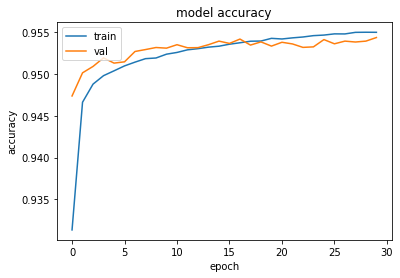

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
preds = model.predict(X_valid).reshape(-1)

In [ ]:
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     61365
           1       0.66      0.50      0.57      3942

    accuracy                           0.95     65307
   macro avg       0.82      0.74      0.77     65307
weighted avg       0.95      0.95      0.95     65307



**Кажется, что последний вариант с конкатенацией и суммированием сработал получше**

# Эксперименты с параметрами и нормализацией. Лемматизация

Лемматизировала со spacy

In [ ]:
%%time
vocab = Counter()

for text in quora.question_text:
    vocab.update(lemmatize(text))

len(vocab)

CPU times: user 3min 18s, sys: 400 ms, total: 3min 19s
Wall time: 3min 19s


In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 10:
        filtered_vocab.add(word)

len(filtered_vocab)

26457

In [ ]:
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [ ]:
X=[]

for text in quora.question_text:
    tokens = lemmatize(text)
    ids = [word2id.get(token, word2id['UNK']) for token in tokens]
    X.append(ids)

MAX_LEN = max(len(x) for x in X)
MAX_LEN
#spacy разбивает сокращения, поэтому MAX_LEN увеличилась

138

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape

(1306122, 138)

In [ ]:
y = quora.target.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)

##Эмбеддинги

In [ ]:
texts = quora.question_text.apply(lemmatize).tolist()

Word2Vec

In [ ]:
%%time
sg = gensim.models.Word2Vec(texts, size=200, window=10, min_count=10, sg=0, iter=2)

CPU times: user 1min 49s, sys: 386 ms, total: 1min 50s
Wall time: 1min 1s


In [ ]:
sg.most_similar('abortion')
# хмммммм

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('homosexuality', 0.7007968425750732),
 ('rape', 0.6971375942230225),
 ('homosexual', 0.6882847547531128),
 ('violence', 0.6670286655426025),
 ('rapist', 0.6596417427062988),
 ('murder', 0.6408506035804749),
 ('feminist', 0.6400958299636841),
 ('fetus', 0.632003903388977),
 ('accusation', 0.6220125555992126),
 ('pedophile', 0.6205482482910156)]

In [ ]:
%%time
sg1 = gensim.models.Word2Vec(texts, size=200, window=10, min_count=10, sg=1, iter=10)


CPU times: user 30min 21s, sys: 2.51 s, total: 30min 23s
Wall time: 15min 30s


In [ ]:
# sg1.most_similar('abortion')
sg1.most_similar('feminism')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('feminist', 0.6941753625869751),
 ('equality', 0.6894516944885254),
 ('misandry', 0.6790188550949097),
 ('feminazi', 0.6295152306556702),
 ('misandrist', 0.627777099609375),
 ('patriarchy', 0.6254380941390991),
 ('masculinity', 0.6093608140945435),
 ('feminazis', 0.6076981425285339),
 ('egalitarianism', 0.6066161394119263),
 ('chivalry', 0.5996068120002747)]

In [ ]:
import numpy as np
# генерируем рандомные вектора
unk_vec = np.random.random(200)
oov_vec = np.random.random(200)

In [ ]:
weights_sg1 = np.zeros((len(word2id), 200))
for word, i in word2id.items():
    if word == 'PAD':
        continue
    if word == 'UNK':
        weights_sg1[i] = unk_vec
    
    try:
        weights_sg1[i] = sg1[word]
    except KeyError:
        weights_sg1[i] = oov_vec

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


Fasttext

In [ ]:
%%time
ft2 = gensim.models.FastText(texts, size=200, window=10, min_count=10, iter=10)

CPU times: user 34min 55s, sys: 3.95 s, total: 34min 59s
Wall time: 17min 56s


In [ ]:
ft2.most_similar('abortion')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('extortion', 0.8099675178527832),
 ('abort', 0.8073110580444336),
 ('conservation', 0.714391827583313),
 ('vaccination', 0.7136491537094116),
 ('distortion', 0.7116754055023193),
 ('abolition', 0.7032406330108643),
 ('miscegenation', 0.7027961015701294),
 ('consensus', 0.6999878287315369),
 ('abomination', 0.6987444162368774),
 ('homosexuality', 0.6971116662025452)]

In [ ]:
weights2 = np.zeros((len(word2id), 200))
for word, i in word2id.items():
    if word == 'PAD':
        continue
    if word == 'UNK':
        weights2[i] = ft2['qzowozmixwm']
    
    try:
        weights2[i] = ft2[word]
    except KeyError:
        weights2[i] = ft2['fhslhdslfhgdku']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                       trainable=False, weights=[weights_sg1])(inputs)
embeddings2 = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                        trainable=False, weights=[weights2])(inputs)
emb = tf.keras.layers.Concatenate()([embeddings, embeddings2])
# сумма
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(emb)
# всякие функции активации
dense1 = tf.keras.layers.Dense(64, activation='relu')(mean)
dense2 = tf.keras.layers.Dense(128, activation='tanh')(dense1)
# LeakyReLU мне не понравилась
dense3 = tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(dense2)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=10)

Epoch 1/10
2424/2424 [==============================] - 153s 63ms/step - loss: 0.1466 - accuracy: 0.9444 - val_loss: 0.1272 - val_accuracy: 0.9495
Epoch 2/10
2424/2424 [==============================] - 155s 64ms/step - loss: 0.1262 - accuracy: 0.9496 - val_loss: 0.1215 - val_accuracy: 0.9507
Epoch 3/10
2424/2424 [==============================] - 154s 64ms/step - loss: 0.1217 - accuracy: 0.9512 - val_loss: 0.1205 - val_accuracy: 0.9509
Epoch 4/10
2424/2424 [==============================] - 155s 64ms/step - loss: 0.1190 - accuracy: 0.9521 - val_loss: 0.1175 - val_accuracy: 0.9520
Epoch 5/10
2424/2424 [==============================] - 155s 64ms/step - loss: 0.1171 - accuracy: 0.9527 - val_loss: 0.1161 - val_accuracy: 0.9528
Epoch 6/10
2424/2424 [==============================] - 158s 65ms/step - loss: 0.1154 - accuracy: 0.9534 - val_loss: 0.1152 - val_accuracy: 0.9528
Epoch 7/10
2424/2424 [==============================] - 156s 65ms/step - loss: 0.1141 - accuracy: 0.9538 - val_loss: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


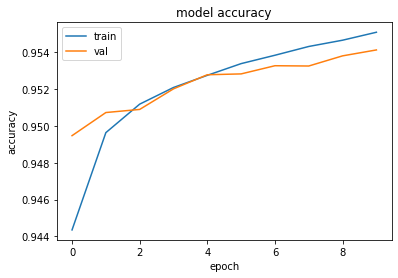

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
preds = model.predict(X_valid).reshape(-1)

In [ ]:
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     61365
           1       0.65      0.53      0.58      3942

    accuracy                           0.95     65307
   macro avg       0.81      0.75      0.78     65307
weighted avg       0.95      0.95      0.95     65307



Mean instead of sum - раньше мы суммировали эмбеддинги 

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                       trainable=False, weights=[weights_sg1])(inputs)
embeddings2 = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                        trainable=False, weights=[weights2])(inputs)
emb = tf.keras.layers.Concatenate()([embeddings, embeddings2])
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1))(emb)
dense1 = tf.keras.layers.Dense(64, activation='relu')(mean)
dense2 = tf.keras.layers.Dense(128, activation='tanh')(dense1)
dense3 = tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(dense2)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=10)

Epoch 1/10
2424/2424 [==============================] - 159s 66ms/step - loss: 0.1641 - accuracy: 0.9444 - val_loss: 0.1249 - val_accuracy: 0.9506
Epoch 2/10
2424/2424 [==============================] - 156s 64ms/step - loss: 0.1240 - accuracy: 0.9504 - val_loss: 0.1191 - val_accuracy: 0.9520
Epoch 3/10
2424/2424 [==============================] - 156s 64ms/step - loss: 0.1202 - accuracy: 0.9518 - val_loss: 0.1171 - val_accuracy: 0.9526
Epoch 4/10
2424/2424 [==============================] - 155s 64ms/step - loss: 0.1181 - accuracy: 0.9526 - val_loss: 0.1150 - val_accuracy: 0.9534
Epoch 5/10
2424/2424 [==============================] - 156s 64ms/step - loss: 0.1165 - accuracy: 0.9530 - val_loss: 0.1140 - val_accuracy: 0.9540
Epoch 6/10
2424/2424 [==============================] - 154s 64ms/step - loss: 0.1152 - accuracy: 0.9536 - val_loss: 0.1129 - val_accuracy: 0.9544
Epoch 7/10
2424/2424 [==============================] - 153s 63ms/step - loss: 0.1141 - accuracy: 0.9541 - val_loss: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


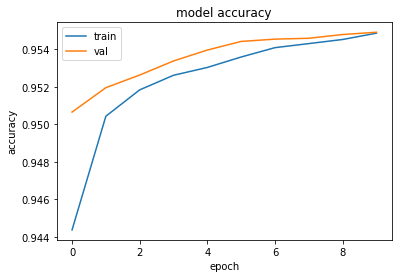

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
preds = model.predict(X_valid).reshape(-1)

In [ ]:
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     61365
           1       0.67      0.50      0.57      3942

    accuracy                           0.95     65307
   macro avg       0.82      0.74      0.77     65307
weighted avg       0.95      0.95      0.95     65307



Вообще я делала эту домашку очень давно, но в тогда я сделала вывод, что *average of embeddings brings down toxic class recall.*. Имеется в виду в сравнении с их суммированием.

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                       trainable=False, weights=[weights_sg1])(inputs)
embeddings2 = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                        trainable=False, weights=[weights2])(inputs)
emb = tf.keras.layers.Concatenate()([embeddings, embeddings2])
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(emb)
dense0 = tf.keras.layers.Dense(64, activation='relu')(mean)
dense1 = tf.keras.layers.Dense(128, activation='relu')(dense0)
dense2 = tf.keras.layers.Dense(256, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(128, activation='relu')(dense2)
dense4 = tf.keras.layers.Dense(64, activation='relu')(dense3)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense4)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=30)

Epoch 1/30
2424/2424 [==============================] - 164s 68ms/step - loss: 0.1482 - accuracy: 0.9456 - val_loss: 0.1265 - val_accuracy: 0.9510
Epoch 2/30
2424/2424 [==============================] - 163s 67ms/step - loss: 0.1261 - accuracy: 0.9502 - val_loss: 0.1208 - val_accuracy: 0.9521
Epoch 3/30
2424/2424 [==============================] - 163s 67ms/step - loss: 0.1208 - accuracy: 0.9517 - val_loss: 0.1187 - val_accuracy: 0.9532
Epoch 4/30
2424/2424 [==============================] - 163s 67ms/step - loss: 0.1176 - accuracy: 0.9528 - val_loss: 0.1175 - val_accuracy: 0.9525
Epoch 5/30
2424/2424 [==============================] - 164s 68ms/step - loss: 0.1153 - accuracy: 0.9534 - val_loss: 0.1147 - val_accuracy: 0.9534
Epoch 6/30
2424/2424 [==============================] - 162s 67ms/step - loss: 0.1135 - accuracy: 0.9539 - val_loss: 0.1148 - val_accuracy: 0.9536
Epoch 7/30
2424/2424 [==============================] - 163s 67ms/step - loss: 0.1119 - accuracy: 0.9545 - val_loss: 0

**Последнюю сеть я обучила два раза, батчами по 512 и по 1024.**

Вот какая вышла разница:

Картинка красивее для батча побольше, но, глядя на метрики для токсичного класса, можно сказать, что батч меньшего размера дал результат получше.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


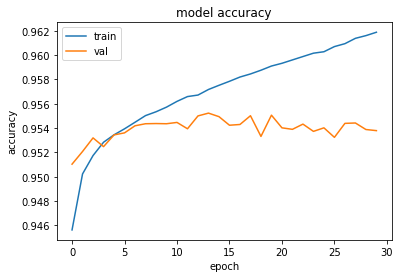

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
preds = model.predict(X_valid).reshape(-1)

In [ ]:
print(classification_report(y_valid, (preds > 0.3).astype(int)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     61365
           1       0.56      0.67      0.61      3942

    accuracy                           0.95     65307
   macro avg       0.77      0.82      0.79     65307
weighted avg       0.95      0.95      0.95     65307



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


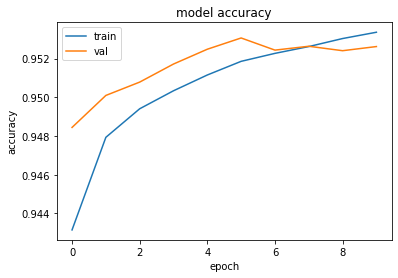

In [ ]:
# 1024 batch
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
preds = model.predict(X_valid).reshape(-1)

In [ ]:
print(classification_report(y_valid, (preds > 0.3).astype(int)))
# 1024 batch

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     61365
           1       0.55      0.65      0.60      3942

    accuracy                           0.95     65307
   macro avg       0.76      0.81      0.78     65307
weighted avg       0.95      0.95      0.95     65307

